In [ ]:
# This program attempts to optimize a users portfolio using the efficient frontier

In [1]:
pip install yfinance

In [3]:
# import python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from datetime import datetime as dt
import yfinance as yf
plt.style.use('fivethirtyeight')


In [4]:
# Get the stocks/portfolio start date and end date
start='2013-01-01'
end= dt.today().strftime('%Y-%m-%d')

In [5]:
meta=yf.download('META', start=start, end=end, auto_adjust=False)
amzn=yf.download('AMZN', start=start, end=end, auto_adjust=False)
aapl=yf.download('AAPL', start=start, end=end, auto_adjust=False)
nflx=yf.download('NFLX', start=start, end=end, auto_adjust=False)
goog=yf.download('GOOG', start=start, end=end, auto_adjust=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
stocks=pd.concat([meta['Adj Close'], amzn['Adj Close'], aapl['Adj Close'], nflx['Adj Close'], goog['Adj Close']], axis=1)
stocks.columns=['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
stocks

,META,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,27.847227,12.865500,16.647179,13.144286,17.907286
2013-01-03,27.618483,12.924000,16.437067,13.798571,17.917688
2013-01-04,28.603083,12.957500,15.979216,13.711429,18.271744
2013-01-07,29.259480,13.423000,15.885217,14.171429,18.192019
2013-01-08,28.901443,13.319000,15.927973,13.880000,18.156120
...,...,...,...,...,...
2025-06-12,692.826904,213.240005,199.199997,1215.030029,176.970001
2025-06-13,682.344971,212.100006,196.449997,1212.150024,175.880005
2025-06-16,702.119995,216.100006,198.419998,1225.349976,177.940002


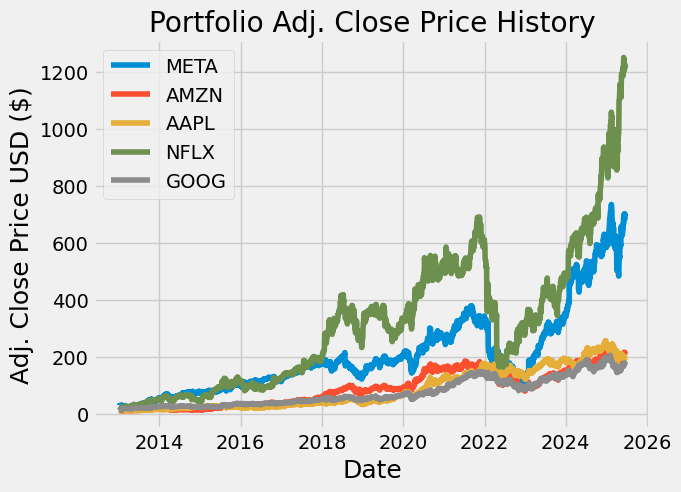

In [7]:
# Visualise stock/portfolio
title = 'Portfolio Adj. Close Price History'
my_stocks=stocks
for c in my_stocks.columns.values:
  plt.plot(my_stocks[c], label=c)
plt.title(title)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj. Close Price USD ($)', fontsize=18)
plt.legend(my_stocks.columns.values, loc='upper left')
plt.show()

In [49]:
returns=stocks.pct_change()
returns_cleaned = returns[(returns > -0.99) & (returns < 5.0)]
logReturns=returns
logReturns
# logReturns = np.log(1 + returns)
# returns
# logReturns = np.log(returns)
# logReturns

,META,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.008214,0.004547,-0.012621,0.049777,0.000581
2013-01-04,0.035650,0.002592,-0.027855,-0.006315,0.019760
2013-01-07,0.022948,0.035925,-0.005883,0.033549,-0.004363
2013-01-08,-0.012237,-0.007748,0.002692,-0.020565,-0.001973
...,...,...,...,...,...
2025-06-12,-0.001124,0.000188,0.002113,-0.003976,-0.010179
2025-06-13,-0.015129,-0.005346,-0.013805,-0.002370,-0.006159
2025-06-16,0.028981,0.018859,0.010028,0.010890,0.011713


In [50]:
import random as random
# return vs volatility chart
noOfPortfolios = 1000
weight=np.zeros((noOfPortfolios,5))
meanLogRet=logReturns.mean()
Sigma=logReturns.cov()
expectedReturn=np.zeros(noOfPortfolios)
expectedVolatility=np.zeros(noOfPortfolios)
sharpeRatio=np.zeros(noOfPortfolios)


for k in range(noOfPortfolios):
  # generate random weight vector
  w=np.array(np.random.random(5))
  w=w/np.sum(w)
  weight[k,:]=w
  expectedReturn[k]=np.sum(meanLogRet*w)
  expectedVolatility[k] = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
  sharpeRatio[k]=expectedReturn[k]/expectedVolatility[k]

In [51]:
maxIndex= sharpeRatio.argmax()
weight[maxIndex,:]

array([1.62795427e-01, 1.25109018e-01, 3.56559766e-01, 3.55410741e-01,
       1.25048369e-04])

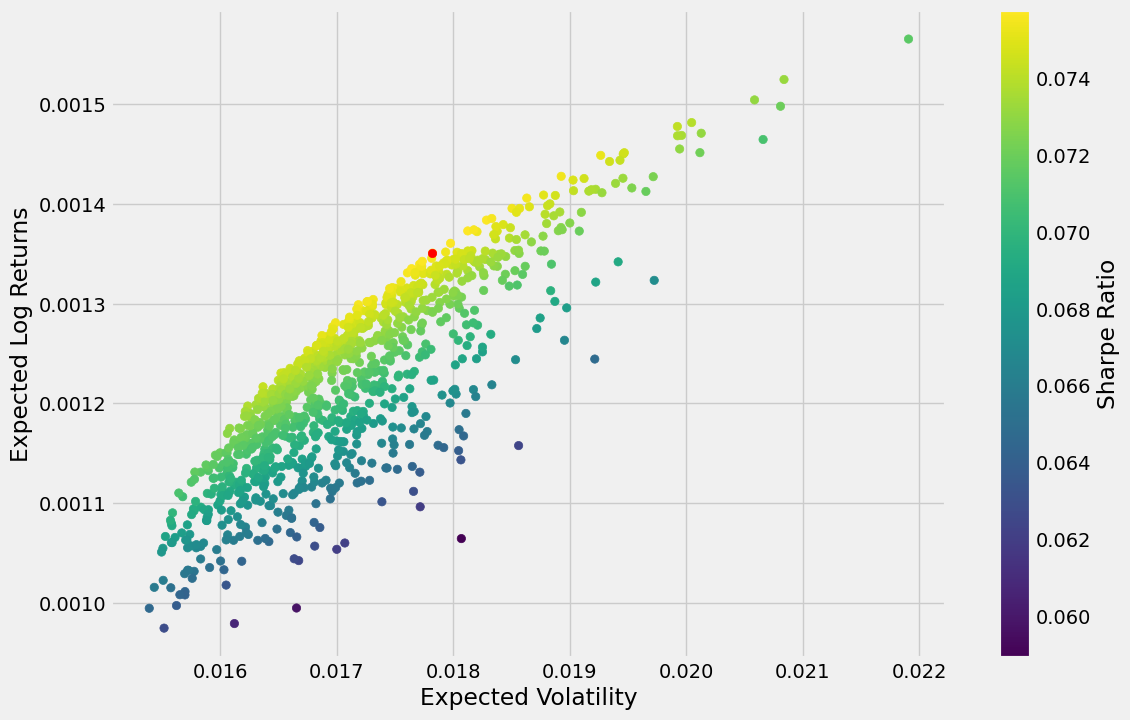

In [52]:
plt.figure(figsize=(12,8))
plt.scatter(expectedVolatility, expectedReturn, c=sharpeRatio)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.scatter(expectedVolatility[maxIndex],expectedReturn[maxIndex], c='red')
plt.show()

In [53]:
# Effective Markovitzch
from scipy.optimize import minimize

def negativeSR(w):
  w=np.array(w)
  R=np.sum(meanLogRet*w)
  V=np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
  SR=(R/V)
  return -1*SR
def checkSumToOne(w):
  return np.sum(w)-1

w0=[0.2, 0.2, 0.2, 0.2, 0.2]
bounds=[(0,1), (0,1), (0,1), (0,1), (0,1)]
constraints={'type':'eq', 'fun':checkSumToOne}

w_opt=minimize(negativeSR, w0, method='SLSQP', bounds=bounds, constraints=constraints)



In [54]:
w_opt.x

array([0.18586834, 0.10913472, 0.31175558, 0.36589484, 0.02734651])

In [55]:
maxIndex= sharpeRatio.argmax()
weight[maxIndex,:]

array([1.62795427e-01, 1.25109018e-01, 3.56559766e-01, 3.55410741e-01,
       1.25048369e-04])

In [59]:
# Use the SciPy optimized weights for your performance calculation
optimal_weights = w_opt.x  # Use this instead of weight[maxIndex,:]

# Calculate performance metrics
port_variance = np.dot(optimal_weights.T, np.dot(Sigma, optimal_weights))
port_volatility = np.sqrt(port_variance)
portfolio_expected_return = np.sum(meanLogRet * optimal_weights)

# Annualize the metrics
annual_return = portfolio_expected_return * 252
annual_volatility = port_volatility * np.sqrt(252)
annual_variance = port_variance * 252

# Format as percentages
percent_var = str(round(annual_variance, 4) * 100) + '%'
percent_vol = str(round(annual_volatility, 4) * 100) + '%'
percent_ret = str(round(annual_return, 4) * 100) + '%'

print('SCIPY OPTIMIZED PORTFOLIO PERFORMANCE:')
print('=' * 45)
print('Expected annual return: ' + percent_ret)
print('Annual volatility/risk: ' + percent_vol)
print('Annual variance: ' + percent_var)

SCIPY OPTIMIZED PORTFOLIO PERFORMANCE:
Expected annual return: 34.38%
Annual volatility/risk: 28.549999999999997%
Annual variance: 8.15%


In [60]:
# Use the SciPy optimized weights for your performance calculation
optimal_weights = weight[maxIndex,:]

# Calculate performance metrics
port_variance = np.dot(optimal_weights.T, np.dot(Sigma, optimal_weights))
port_volatility = np.sqrt(port_variance)
portfolio_expected_return = np.sum(meanLogRet * optimal_weights)

# Annualize the metrics
annual_return = portfolio_expected_return * 252
annual_volatility = port_volatility * np.sqrt(252)
annual_variance = port_variance * 252

# Format as percentages
percent_var = str(round(annual_variance, 4) * 100) + '%'
percent_vol = str(round(annual_volatility, 4) * 100) + '%'
percent_ret = str(round(annual_return, 4) * 100) + '%'

print('SCIPY OPTIMIZED PORTFOLIO PERFORMANCE:')
print('=' * 45)
print('Expected annual return: ' + percent_ret)
print('Annual volatility/risk: ' + percent_vol)
print('Annual variance: ' + percent_var)

SCIPY OPTIMIZED PORTFOLIO PERFORMANCE:
Expected annual return: 34.04%
Annual volatility/risk: 28.29%
Annual variance: 8.0%


In [57]:
returns=np.linspace(0,0.0016,50)
volatility_opt=[]

def minimizeVolatility(w):
  w=np.array(w)
  R=np.sum(meanLogRet*w)
  V=np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
  return V

def getReturn(w):
  w=np.array(w)
  R=np.sum(meanLogRet*w)
  return R

for R in returns:
  constraints=({'type':'eq','fun':checkSumToOne},
               {'type':'eq','fun':lambda w: getReturn(w)-R})
  opt=minimize(minimizeVolatility, w0, method='SLSQP', bounds=bounds, constraints=constraints)
  volatility_opt.append(opt['fun'])


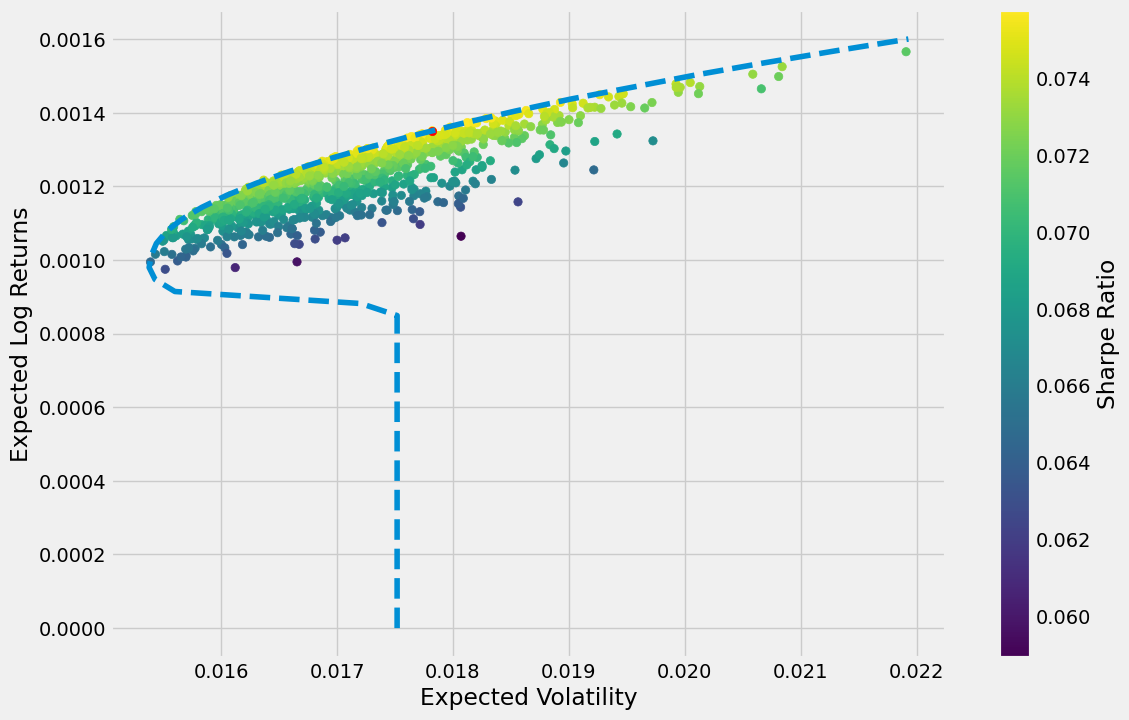

In [58]:
plt.figure(figsize=(12,8))
plt.scatter(expectedVolatility, expectedReturn, c=sharpeRatio)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.scatter(expectedVolatility[maxIndex],expectedReturn[maxIndex], c='red')
plt.plot(volatility_opt,returns,'--' )
plt.show()